In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from simple_plot import *

# Ch. 8 - Finite Difference Methods

We now make the leap from ordinary differential equations (ODEs) to __partial differential equations (PDEs)__ that involve more than one independent variable. The chapter starts looking at how to apply finite difference methods similar to those introduced in Ch. 7, and then moves on to consider an alternative approach based on Fourier transforms.

Before we get into the details, let's quickly review classification of PDEs that arise frequently in engineering. Let's start with the general __$2^{nd}$-order Quasi-linear PDE__. 
$$A(x,y) \frac{\partial^2 u}{\partial x^2}+2B(x,y) \frac{\partial^2 u}{\partial x \partial y}+C(x,y) \frac{\partial^2 u}{\partial y^2} = F(x,y,u, \frac{\partial u}{\partial x}, \frac{\partial u}{\partial y})$$

It is common to use $x,y,z, \text{and } t$ as independent variables, so we will designate the dependent variable as $u$, $\psi$, or $\omega$. It is also common to use subscripts (sometimes preceded by a comma) as shorthand for partial derivatives, so the equation above can also be written as:
$$A(x,y) \, u_{xx}+2B(x,y) \, u_{xy}+C(x,y) \, u_{yy} = F(x,y,u, u_x, u_y)$$
If the PDE has __constant coefficients__, then things simplify a bit:
$$A  u_{xx}+2B  u_{xy}+C  u_{yy} = F(x,y,u, u_x, u_y)$$
The usual approach to classification focuses on the highest ($2^{nd}$) order derivatives and considers __characteristic solutions__ of the form $u = f(k x + y)$.

Using the chain rule we find: $$u_x = k f', u_y = f'$$

Plugging into the PDE gives: $$A k^2 f' +2 B k f' + c f' = 0$$

Cancelling $f'$ leaves a quadratic equation to solve for k: $$A k^2 + 2 B k + C = 0$$

The major distinction of interesst involves whether the equation has real roots. 

For real values of $k$:

- values of $u(k x + y)$ are constant along __real characteristic curves (or lines or directions)__ $k x + y =0 $

- information propagates along real characteristics

- "propagates" \implies wave behavior

Existence of real characteristics exist is determined by the __discriminant__ $B^2 - A C$, and the classifications are summarized in the table below:



|   Type        |     Discriminant Value      |   Classic Example   |      Classic Equation    |    Normal Form Equation   |
| -------- | :------------------: | :--------: | :-------------: | :--------------: |
| Hyperbolic     |  $B^2-A C>0$  | Wave |  $u_{tt} = c^2 u_{xx}$     | $u_{vw} = f_1$ |
| Parabolic      |  $B^2-A C=0$  | Heat |  $u_{t} = c^2 u_{xx}$     | $u_{ww} = f_2$ |
| Elliptic      |  $B^2-A C<0$  | Laplace |  $u_{xx} + u_{yy} = 0$     | $u_{vv}+u_{ww} = f_3$ |

We will see that the different classes of equations will have different properties that require choosing appropriate numerical methods.

## Section 8.1 - Finite Difference Discretization

This section in the text opens with a non-trivial example, but let's look at some of the "classics" first starting with Laplace's equation which arises in a variety of applications including gravitation, electrostatics, fluid flow, and just about anything with a potential.

Starting simple with Cartesian coordinates and Dirichlet boundary conditions (BCs), let's compute a numerical solution for the following problem:

$$ \nabla^2 u = \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = 0 \text{ on } x \in [0,L_x]; \; y \in [0,L_y]$$

with boundary conditions:

$$u(0,y)=u(L,y)=u(0,x)=0, \; u(L,x) = U$$

Just as we did for the direct solve method of ODEs, we will discretize the domain to produce a regular grid. Let $n_x$ be the number of grid points interior to the domain along the $x$ direction, so that there will be $n_x + 2$ along the axis (including a boundary point at each end of the interval). There will be $n_x+1$ intervals along the axis, so the spacing between the nodes is $\Delta x = L_x/(n_x + 1)$, and the discrete coordinate values are $x_i = (i+1) \Delta x, \; i \in [0,n_x -1]$. 

(Here we have maintained python indexing (`i in range(nx)`) in the interior, so the boundary corresponds to $x_{-1} = 0$ and $x_{nx} = Lx$.)


In [2]:
Lx = 1
nx = 4
x = np.linspace(0,Lx,nx + 2) #linspace across full domain including boundaries
dx = Lx/(nx+1) #spacing between nodes
x_in = x[1:-1] #x-coords of interior points

Similarly for $y$, the spacing between the nodes is $\Delta y = L_y/(n_y + 1)$, and the discrete coordinate values are $y_j = (j+1) \Delta y, \; j \in [0,n_y -1]$

In [5]:
Ly = 1
ny = 4
y = np.linspace(0,Ly,ny + 2) #linspace across full domain including boundaries
dy = Ly/(ny+1) #spacing between nodes
y_in = y[1:-1] #y-coords of interior points
y_in

array([0.2, 0.4, 0.6, 0.8])

In [6]:
np.meshgrid(x,y)

[array([[0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. ]]),
 array([[0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
        [0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
        [0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
        [1. , 1. , 1. , 1. , 1. , 1. ]])]

Now the continuous domain has been replaced by a discrete grid of points, $(x_i, y_j)$, and we aim to solve for the values of the dependent variable on the grid:

$$u_{i,j} = u(x_i, y_j) = u\big( (i+1) \Delta x, (j+1) \Delta y \big)$$ 

We get an equation for each (internal) grid point by replacing the derivatives with central difference approximations:

\begin{equation}
\begin{split}
\frac{\partial^2u}{\partial x^2} & \rightarrow \frac{1}{\Delta x^2}(u_{i-1,j}-2u_{i,j}+u_{i+1,j}) \\
\frac{\partial^2u}{\partial y^2} & \rightarrow \frac{1}{\Delta y^2} (u_{i,j-1} -2 u_{i,j} + u_{i,j+1})
\end{split}
\end{equation}

Each equation then takes the form :

$$ \nabla^2 u = \frac{\partial ^2 u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \rightarrow u_{i-1,j}+u_{i+1,j}+u_{i,j-1} + u_{i,j+1} -4u_{i,j} = 0$$

This quantity is more readable in code format:

`u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1] + 4*u[i,j]`

This is a classic __stencil computation__: we can think about obtaining this quantity byplacing a stencil of coefficients on top of a grid point and performing an "inner product" by multiplying the stencil coefficient by the grid value it covers and then summing. Here we need a "5-point stencil" also referred to as a __tensor product stencil of radius 1__ (because we are using a 1D stencil along each coordinate direction covering 1 neighbor in each direction. The specific stencil is shown below where red/black dots indicate stencil coefficients of $-4$ and $1$ respectively:

![stencil_5point](stencil_5point.png)

If there are no source terms (so the right-hand side of the previous equation is zero, then we can solve for $u_{i,j}$ in terms of the values at the neighboring gridpoints:

$$u_{i,j} = \frac{1}{4} (u_{i-1,j} + u_{i+1,j} +u_{i,j-1} +u_{i,j+1} )$$

and we can employ this as the basis for an explicit iterative solver:

$$u^{k+1}_{i,j} = \frac{1}{4} (u^k_{i-1,j} + u^k_{i+1,j} +u^k_{i,j-1} +u^k_{i,j+1} )$$

Interpreting $k$ as iteration number, the equation suggests repeatedly updating each grid point with the average of the values at the neighboring grid points. Let's implement this and see how it works:

In [7]:
# write a function to update each value as mean of neighbors
def mean_update(u):
    '''
    update 2D array with non-boundary elements replaced by average of 4 nearest neighbors (on Cartesian grid)
    
    Args:
        u: 2D numpy array of floats
        
    Returns:
        u_new: numpy array with same shape as u
    '''
    #insert code here
    return u_new

Create an array initialized with the Dirichlet BCs on the boundary and zeros in the interior:

In [89]:
u = np.zeros([nx,ny])
top_val = 100
#impose BCs
for j in range(ny):
    u[0,j] = top_val
u

array([[100., 100., 100., 100.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

Test the `mean_update` function:

In [90]:
u = mean_update(u)
u

array([[100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ],
       [  0.  ,  47.73,  64.91,  70.84,  70.84,  64.91,  47.73,   0.  ],
       [  0.  ,  26.03,  41.12,  47.67,  47.67,  41.12,  26.03,   0.  ],
       [  0.  ,  15.31,  25.94,  31.14,  31.14,  25.94,  15.31,   0.  ],
       [  0.  ,   9.31,  16.3 ,  19.93,  19.93,  16.3 ,   9.31,   0.  ],
       [  0.  ,   5.7 ,  10.13,  12.51,  12.51,  10.13,   5.7 ,   0.  ],
       [  0.  ,   3.43,   6.13,   7.61,   7.61,   6.13,   3.43,   0.  ],
       [  0.  ,   1.93,   3.46,   4.31,   4.31,   3.46,   1.93,   0.  ],
       [  0.  ,   0.87,   1.56,   1.94,   1.94,   1.56,   0.87,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]])

That looks OK, so run a larger version:

### Sample implementation below:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from simple_plot import *

# write a function to update each value as mean of neighbors
def mean_update(u):
    '''
    update 2D array with non-boundary elements replaced by average of 4 nearest neighbors (on Cartesian grid)
    
    Args:
        u: 2D numpy array of floats
        
    Returns:
        u_new: numpy array with same shape as u
    '''
    nx, ny = np.shape(u)
    u_new = np.copy(u)
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            u_new[i,j] = (u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1])/4.
    return u_new

In [10]:
#intialize x discretization
Lx = 1
nx = 35
x = np.linspace(0,Lx,nx + 2) #linspace across full domain including boundaries
dx = Lx/(nx+1) #spacing between nodes
x_in = x[1:-1] #x-coords of interior points

#intialize y discretization
Ly = 1
ny = 20
y = np.linspace(0,Ly,ny + 2) #linspace across full domain including boundaries
dy = Ly/(ny+1) #spacing between nodes
y_in = y[1:-1] #y-coords of interior points
y_in

#intialize the 2D array
u = np.zeros([nx+2,ny+2]) #include boundary points
top_val = 100
#impose BCs
for j in range(ny+2):
    u[0,j] = top_val

tol = 1e-2
max_iter = 60
du = np.zeros(max_iter)
for k in range(max_iter):
    u_new = mean_update(u)
    du_max = np.max(np.abs(u-u_new))
    du[k] = du_max
    u = u_new
    if du_max < tol:
        break
np.set_printoptions(precision=2)
print(u)
np.set_printoptions(precision=5)
print(du)
np.set_printoptions(precision=2)

[[1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02
  1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02
  1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02 1.00e+02]
 [0.00e+00 4.90e+01 6.77e+01 7.60e+01 8.02e+01 8.24e+01 8.37e+01 8.45e+01
  8.49e+01 8.51e+01 8.52e+01 8.52e+01 8.51e+01 8.49e+01 8.45e+01 8.37e+01
  8.24e+01 8.02e+01 7.60e+01 6.77e+01 4.90e+01 0.00e+00]
 [0.00e+00 2.82e+01 4.60e+01 5.64e+01 6.25e+01 6.61e+01 6.83e+01 6.96e+01
  7.04e+01 7.08e+01 7.10e+01 7.10e+01 7.08e+01 7.04e+01 6.96e+01 6.83e+01
  6.61e+01 6.25e+01 5.64e+01 4.60e+01 2.82e+01 0.00e+00]
 [0.00e+00 1.80e+01 3.19e+01 4.14e+01 4.77e+01 5.18e+01 5.43e+01 5.59e+01
  5.69e+01 5.75e+01 5.77e+01 5.77e+01 5.75e+01 5.69e+01 5.59e+01 5.43e+01
  5.18e+01 4.77e+01 4.14e+01 3.19e+01 1.80e+01 0.00e+00]
 [0.00e+00 1.22e+01 2.25e+01 3.03e+01 3.58e+01 3.97e+01 4.22e+01 4.39e+01
  4.49e+01 4.55e+01 4.58e+01 4.58e+01 4.55e+01 4.49e+01 4.39e+01 4.22e+01
  3.97e+01 3.58e+01 3.03e+01 2.2

C:\Users\storti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


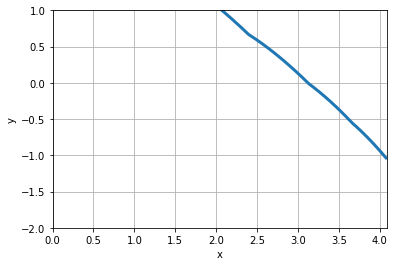

In [11]:
t = range(max_iter)
arrayplot(np.log(t), np.log(du), axis_range=[0,np.log(max_iter),-2,1],grid=True)

In [12]:
x.shape, y.shape, u.shape

((37,), (22,), (37, 22))

In [13]:
X,Y = np.meshgrid(x,y)
X.shape,Y.shape,u.shape

((22, 37), (22, 37), (37, 22))

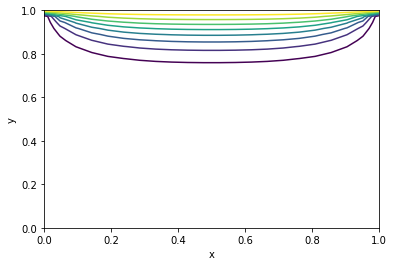

In [21]:
arraycontourplot(1-x,y, u, levels=np.linspace(0,100,10),
    titlestring='', filled=False)

# OLD STUFF BELOW TO BE DELETED...

Euler's method essentially computes the rate of change at the beginning of a time step (from $t_n$ to $t_{n+1}$) and ignores the change in that rate of change over short time steps. This assumption is, of course, not completely valid so truncation error is incurred.

There are numerous generalizations of Euler's method of the form $$y_{n+1} = y_n + h \phi$$ where the function $\phi$ is chosen to reduce the error incurred during the timestep. For example, the Euler formula can be used to estimate future values and the estimated derivatives at those times can be used to account for how the rate of change varies across the timestep.

__Heun's method__: 

1) Compute the right-hand side (RHS) at initial time (left end of the timestep).

2) Compute Euler estimate of $y_{t+h}$

3) Use Euler estimate to compute estimate of derivative at final time (right end of the timestep)

4) Use the average of the derivatie estimates from left and right ends

Euler: $$y_{n+1} = y_n + h f(t_n, y_n)$$

$$y_{Euler} = y(t) + h f(t,f(t,y(t))$$

$$y(t+h) = y(t) + \frac{h}{2} \big( f(t,y(t)) + f(t+h,y_{Euler}) \big); \qquad \mathrm{Eq. (7.1.13a)}$$

__Modified Euler-Cauchy__:

1) Compute derivate (RHS) at initial time (left side of interval)

2) Use that derivative value to compute "Euler" estimate of derivative at middle of interval.

3) Use mid-interval value to estimate rate of change over the interval.

$$rate_{left} = f(t, y(t))$$
$$y_{mid} = y(t) + \frac{h}{2} rate_{left}$$
$$rate_{mid} = f(t+\frac{h}{2}, y_{mid})$$
$$y_{RK2}(t+h) = y(t) + h (rate_{mid})$$

Put the pieces together:
$$y_{RK2}(t+h) = y(t)+h f\big(t+\frac{h}{2}, y(t)+\frac{h}{2} \; f(t,y(t)) \big); \qquad \mathrm{Eq. 7.1.13b}$$

If that is the modified Euler-Cauchy method, why is the subscript "RK2"?

Euler's method and the modified Euler-Cauchy method are actually the first 2 methods in the family of __Runge-Kutta methods__ that aim to reduce the truncation error (i.e. increase the order by making the neglected terms involve higher powers of $h$) by including rate estimates at additional points in the timestep.

Perhaps the most commonly used member of the family is __Fourth-Order Runge_Kutta (RK4)__:

1) Compute initial rate estimate
$$f_1 = f(t_n,y_n)$$

2) Use initial rate estimate to estimate midstep values
$$f_2 = f(t_n+\frac{h}{2}, y_n+\frac{h}{2}f_1)$$

3) Use the midstep estimate to compute improved midstep estimate
$$f_3 = f(t_n+\frac{h}{2}, y_n+\frac{h}{2}f_2)$$

4) Use improved midstep estimate to estimate right-side estimate
$$f_4 = f(t_n+h,y_n+h f_3)$$

5) Compute weighted sum  of contributions to cancel terms in the Taylor series. <br>Achieve local truncation error $\sim O(h^5) \implies$ global error $\sim O(h^4)$:
$$y_{n+1} = y_n + \frac{h}{6} [f_1 + 2 f_2 +2 f_3 + f_4]$$

We will return to take a closer look at error analysis, but for now let's pause to think about what is nice about Runge-Kutta methods:

Do you need previous values of $y$ (before $y_n$) to compute $y_{n+1}$?

__No__, so when you are given $y_0$ and $f(t,y)$ you have everything needed to compute $y_{n+1} \iff$ __self-starting__

Computing the RK4 estimate involves computing everythign we need for the lower order RK2 estimate. What could we do with such information?

Estimate local error $\implies$ possible to implement automated adaptive stepsize control.

### Adams method: Multi-stepping techniques

What we were really doing above is approximating the fundamental theorem of calculus (that a function is the integral of its derivative):
$$y_{n+1} = y_n + \int_{t_n}^{t_n + h} f(t,y) dt$$

For Runge-Kutta, we estimated the interval based on information at $t_n$. Adams methods take an alternative approach:

Use previous values to construct a locally valid polynomial approximant $p(t,y)$ and integrate the polynomial:
$$y_{n+1} = y_n + \int_{t_n}^{t_n + h} p(t,y) dt$$

__Adams-Bashforth methods__ construct the polynomial based on the current point and $n$ previous points.

The first member of the family with $n=0$ uses an order 0 polynomial:
$$p_1(t) = \mathrm{constant} = f(t_n, y_n)$$
leading to
$$y_{n+1} = y_n + h f(t_n,y_n)$$
which should look familiar (because it is Euler's method).

__Note on notation__: The convention followed in the book is that the subscript on the polynomial indicates the number of points used, so it is one greater than the degree of the polynomial.

We start to get something new when we use 2 points, $y_{n-1}, y_n$, and a polynomial of degree 1:
$$p_2 = f_{n-1}+\frac{f_n-f_{n-1}}{h}(t-t_{n-1})$$
$$y_{n+1}=y_n + \int_{t_n}^{t_n + h} p(t,y) dt$$
$$y_{n+1}=y_n + \int_{t_n}^{t_n + h} \big( f_{n-1}+\frac{f_n-f_{n-1}}{h}(t-t_{n-1})\big) dt$$
$$y_{n+1}=y_n + \frac{h}{2} \big[ 3 f(t_n,y_n) - f(t_{n-1},y_{n-1}) \big]; \qquad \mathrm{Eq.(7.1.23)}$$
This is a _two-step method_:
Need $y_{n-1}$ and $y_n$ to compute $y_{n+1}$, so NOT self-starting.
<br>Consider initial state: given $y_0$ not enough into to compute $y_1$
<br>Need __bootstrapping__ technique to get started



Let's look at implementations of these basic methods:

### Euler's method (START HERE Tuesday 1/28/20)

Let's start with a familiar initial value problem:
$$\frac{dy}{dt}=-y\; ; \qquad y(0) = 1$$

In [120]:
import numpy as np
import scipy
from scipy import integrate

# define "right-hand side" function giving rate of change
def rhs(y,t):
    """
    compute right-hand side function specifying rate of change
    
    Args:
        t: float value of independent variable
        y: float value of dependent variable
        
    Returns:
        rate: float value for rate of change of y
    """
    rate = -y
    return rate

Now implement a function to take a single step:

In [3]:
def euler_step(f,y,t0,t1):
    """
    compute next value for Euler's method ODE solver
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y: float value of dependent variable
        t0: float initial value of independent variable
        t1: float final value of independent variable
        
    Returns:
        y_new: float estimated value of y(t1)
    """
    f0 = f(y,t0)
    h = (t1-t0)
    y_new = y + h*f0
    return y_new

In [4]:
euler_step(rhs,1,0,.1)

0.9

Construct a multistep Euler solver that can be used for longer intervals:

In [5]:
def euler_solve(f,y0,t):
    """
    Euler ODE solver
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y0: float initial value of dependent variable
        t: numpy array of float values of independent variable
        
    Returns:
        y: numpy array of float values of dependent variable
    """
    n = t.size
    y = [y0] #create solution as a list (of 1D numpy arrays) to which additional array values can be appended
    for i in range(n-1):
        y.append(euler_step(f,y[i],t[i],t[i+1])) #append new value to the list
    return np.array(y) #return the solution coverted to a numpy array

In [6]:
steps = 4
t = np.linspace(0,1,steps+1)
y = euler_solve(rhs,1,t)
print(t)
print(y)

[0.   0.25 0.5  0.75 1.  ]
[1.         0.75       0.5625     0.421875   0.31640625]


Compute values of exact solution $y(t)=exp(-t)$ for comparison:

In [7]:
n = t.size
y_exact = np.zeros(n)
for i in range(n):
    y_exact[i] = np.e**(-t[i])

error = (y_exact - y)
rel_error = (y_exact - y)/y_exact
print(error)
print(rel_error)

[0.         0.02880078 0.04403066 0.05049155 0.05147319]
[0.         0.03698094 0.07259429 0.10689062 0.13991864]


Plot and compare exact solution and approximate solution by Euler's method:

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt # import matplotlib's pyplot function under the abbreviation plt

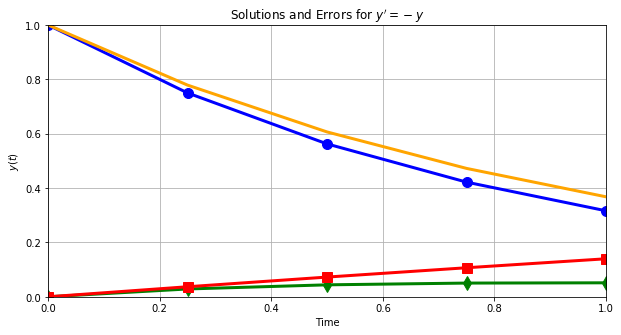

In [167]:
#################################################
#TRICK FOR CONTROLLING SIZE OF PLOTS IN NOTEBOOK#
fig=plt.figure(figsize=(10,5))                  #
#################################################

plt.plot(t,y, color='blue', marker='o', linestyle='solid', linewidth=3, markersize=10) 
plt.plot(t,y_exact, color='orange', marker='', linestyle='solid', linewidth=3, markersize=10)
plt.plot(t,error, color='green', marker='d', linestyle='solid', linewidth=3, markersize=10)
plt.plot(t,rel_error, color='red', marker='s', linestyle='solid', linewidth=3, markersize=10)
plt.axis([0,1,0,1])
plt.title("Solutions and Errors for $y' = -y$")
plt.xlabel("Time")
plt.ylabel("$y(t)$")
plt.grid(True)
# plt.savefig("figure.png") #save the plot to a file
plt.show()

In this case, the $\color{blue}{approximate~solution}$ tracks the $\color{orange}{exact~solution}$ reasonably well. The $\color{green}{absolute~error}$ appears to accumulate initially, and then level off; but this is largely because the exact solution decays exponentially. The $\color{red}{relative~error}$ a grows steadily during the simulation.

Naturally we want to explore how the errors depend on number/size of steps, so compute the error in $y(1)$ for a range of step counts, print, plot, and interpret.

Before doing so, take a moment to think about what kind of results you expect to see. Make some concrete predictions, then proceed.

In [127]:
from timeit import default_timer as timer

m = 8
y1_exact = 1/np.e
steps =  np.zeros(m, dtype=np.int64)
y1 = np.zeros(m)
abs_error = np.zeros(m)
rel_error = np.zeros(m)
timings = np.zeros(m)

for i in range(m):
    steps[i] = 10**i
    t = np.linspace(0,1,steps[i]+1)
    y = np.zeros(steps[i]+1)
    start = timer()
    y1[i] = euler_solve(rhs,1,t)[-1] #take the last entry from the solver corr. to t=1
    end = timer()
    timings[i] = end-start
abs_error = np.abs(y1 - y1_exact)
rel_error = abs_error/y1_exact

np.set_printoptions(precision=2) #set printed output to show 2 digits to right of decimal point
print("Steps:\n", 1.* steps)
print("Relative errors:\n", rel_error)
print("Runtime:\n", timings)

Steps:
 [1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07]
Relative errors:
 [1.00e+00 5.22e-02 5.02e-03 5.00e-04 5.00e-05 5.00e-06 5.00e-07 5.00e-08]
Runtime:
 [1.32e-05 1.24e-05 8.34e-05 8.69e-04 1.08e-02 1.24e-01 8.91e-01 8.46e+00]


The behavior here is clear enough that we can see it without plotting:

Reducing the stepsize (increasing the number of steps) by a factor of 10 decreases the relative error by a factor of 10 throughout the range `1e0` to `1e-8`.

Conclusions:

1) The method has global truncation $\sim O(h^1) \iff $ local truncation error $\sim O(h^2)$.

2) Truncation error dominates throughout the range of stepsizes explored.

3) As `h` becomes smaller, the runtimes become longer (because number of steps $\sim \frac{1}{h}$)..

At smaller stepsizes, we expect to see a minimum error followed by growing dominance of roundoff error. However, the runtimes are becoming intolerable before we get to the minimum error which suggests using alternate methods with higher order accuracy.

But before we move on, let's consider what happens if there is a general multiplicative constant on the right-hand side:
$$\frac{dy}{dt} = -y \qquad \rightarrow \qquad \frac{dy}{dt} = \lambda y$$

We just looked at the case where $\lambda = -1$. Now let's think about other cases:

* $\lambda>0$: What happens in this case?

Exponential growth ensues. The exact solution diverges toward $\infty$. Likewise small initial errors grow large with time...

* Perhaps the more interesting case involves $\lambda < -1$. The exact solution simply decays toward zero faster than before, so what could be the problem with that? Let's construct someother cases and take a look.

We could created a modified version of `rhs` that would take an additional argument, but instead let's introduce a useful python notation for defining short, anonymous functions which, naturally, causes a classic notation collision:

__Python lambda functions__:
The general form is:
`lambda arg1, arg2, ..., argN : expression`

In this case, our expression is going to inolve the constant that is called $\lambda$ in the book, but these are two unrelated things for which the same name has been used:

* `lamdba` is a python keyword for creating one-line anonymous functions

* $\lambda$ is the constant multiplier in the example ODE $y' = -\lambda y$.

With that detail behind us, let's construct an example lambda function and then use lambda functions to conventiently define new right-hand sides for our ODE.

In [157]:
(lambda x : x**2)(4) #anonymous version

16

In [285]:
sq = lambda x : x**2 #can also assign a name to enable reuse
sq(4)

16

In [286]:
#create RHS for coefficients -1, -15, -20, -25
rhs01 = lambda y, t : -y
rhs15 = lambda y, t : -15*y
rhs20 = lambda y, t : -20*y
rhs25 = lambda y, t : -25*y

In [287]:
#Solve the ODE with each RHS using 10 steps on [0,1]
steps = 10
t = np.linspace(0,1,steps+1)
y01 = euler_solve(rhs01,1,t)
y15 = euler_solve(rhs15,1,t)
y20 = euler_solve(rhs20,1,t)
y25 = euler_solve(rhs25,1,t)

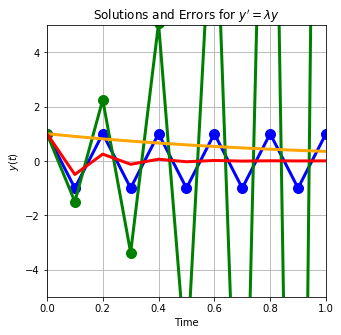

In [288]:
# plot the 10 step Euler solutions
plt.plot(t,y20, color='blue', marker='o', linestyle='solid', linewidth=3, markersize=10) 
plt.plot(t,y25, color='green', marker='o', linestyle='solid', linewidth=3, markersize=10) 
plt.plot(t,y01, color='orange', marker='', linestyle='solid', linewidth=3, markersize=10)
plt.plot(t,y15, color='red', marker='', linestyle='solid', linewidth=3, markersize=10)
plt.axis([0,1,-5,5])
plt.title("Solutions and Errors for $y' = \lambda y$")
plt.xlabel("Time")
plt.ylabel("$y(t)$")
plt.grid(True)
plt.rcParams["figure.figsize"] = [5,5]
# plt.savefig("figure.png") #save the plot to a file
plt.show()

* $\color{orange}{\lambda = -1}$ (the solution obtained previously): Euler solution tracks the exact solution and decays toward zero. 

* $\color{red}{\lambda = -15}$: Euler solution has oscillations that are not present in the exact solution.

* $\color{blue}{\lambda = -20}$: Euler solution oscillates without decaying.

* $\color{green}{\lambda = -25}$: Euler not only oscillations, but also diverges (as the solution grows toward $\infty$). 

The relevant issue here is not accuracy but __stability__. For values of $\lambda$ that are sufficiently negative, solutions exhibit spurious oscillatory behavior ($\lambda < -10$) and eventually diverge ($\lambda < -20$ or $\lambda > 0$). 

Note that this behavior depends on the stepsize: Even for $\lambda= - 25$, both divergence and oscillation are avoided for with a sufficient number of steps (sufficiently small stepsize).


In [289]:
#Solve the ODE with each RHS using 50 steps on [0,1]
steps = 50
t = np.linspace(0,1,steps+1)

y25_50steps = euler_solve(rhs25,1,t)
print(y25_50steps)

[1.00e+00 5.00e-01 2.50e-01 1.25e-01 6.25e-02 3.12e-02 1.56e-02 7.81e-03
 3.91e-03 1.95e-03 9.77e-04 4.88e-04 2.44e-04 1.22e-04 6.10e-05 3.05e-05
 1.53e-05 7.63e-06 3.81e-06 1.91e-06 9.54e-07 4.77e-07 2.38e-07 1.19e-07
 5.96e-08 2.98e-08 1.49e-08 7.45e-09 3.73e-09 1.86e-09 9.31e-10 4.66e-10
 2.33e-10 1.16e-10 5.82e-11 2.91e-11 1.46e-11 7.28e-12 3.64e-12 1.82e-12
 9.09e-13 4.55e-13 2.27e-13 1.14e-13 5.68e-14 2.84e-14 1.42e-14 7.11e-15
 3.55e-15 1.78e-15 8.88e-16]


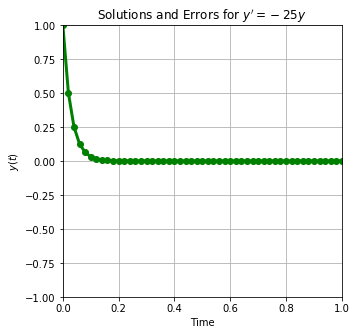

In [290]:
# plot the 50 step Euler solution
 
plt.plot(t,y25_50steps, color='green', marker='o', linestyle='solid', linewidth=3, markersize=6) 
plt.axis([0,1,-1,1])
plt.title("Solutions and Errors for $y' = -25 y$")
plt.xlabel("Time")
plt.ylabel("$y(t)$")
plt.grid(True)
# plt.savefig("figure.png") #save the plot to a file
plt.show()

Before getting into the details of convergence and stability analysis, let's expand the problem scope and explore some of the other numerical solution methods.

### Systems of first order ODEs

So far we have considered examples where the dependent variable $y$ is a scalar function of the independent variable $t$. 

* What happens if we introduce additional __independent variables__?
<br><br><br><br><br><br><br>
That puts into a significantly different world of __partial differential equations (PDEs)__; and we will get tehre soon enough, but not yet.

* What happens if we introduce additional __dependent variables__?
<br><br><br><br><br><br><br>
That is not a big deal: just consider the dependent variable to be a vector quantity $\boldsymbol{y}$.
$$\frac{d \boldsymbol{y}}{dt} = f(\boldsymbol{y}, t)$$

The relevant example in the text is given by Eq. (7.1.33) adjusted for python indexing:

\begin{equation} \label{eq1}
\begin{split}
\frac{d y_0}{dt} & = y_1 \\
\frac{d y_1}{dt} & = y_2 \\
\frac{d y_2}{dt} & = -y_2^2 y_1 -cos(t) y_0 + g(t)
\end{split}
\end{equation}

We can just consider $\boldsymbol{y} = (y_0, y_1, y_2)^T$ and write the system as a vector ODE:
$$\frac{d \boldsymbol{y}}{dt} = \frac{d}{dt} \begin{pmatrix} y_0\\y_1\\y_2 \end{pmatrix}   = \begin{pmatrix} y_1\\y_2\\-y_0^2 y_1 -cos(t) y_0 + g(t) \end{pmatrix} = f(\boldsymbol{y}, t)$$

In [10]:
# define "array right-hand side" function giving rate of change for Eq.(7.1.32) 
# with g(t) = sin(t)

def arr_rhs(y,t):
    """
    compute right-hand side function specifying rate of change
    
    Args:
        t: float value of independent variable
        y: numpy array of 3 floats storing value of dependent variable
        
    Returns:
        rate: numpy array of 3 floats value for rate of change of y
    """
    rate = np.array([y[1],y[2],-y[0]**2 *y[1]-np.cos(t)*y[0]+np.sin(t)])
    return rate

So it is pretty straightforward to define a rate vector, and we can put it work after creating a numpy array of 3 initial values:

In [11]:
y0 = np.array([1,0,0]) #set an array of initial values
arr_rhs(y0,0) #compute the initial rate array

array([ 0.,  0., -1.])

Now that we are computing the numpy array for the rates of change, let's see if our previous `euler_step` function is compatibly computes an updated array of values:

In [12]:
euler_step(arr_rhs, y0, 0, 0.1)

array([ 1. ,  0. , -0.1])

That looks promising, so let's move on to try `euler_solve`:

In [13]:
steps = 10
y0 = np.array([1,0,0])
t = np.linspace(0,1,steps+1)
y = euler_solve(arr_rhs, y0, t)
print(t)
print(y)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[[ 1.          0.          0.        ]
 [ 1.          0.         -0.1       ]
 [ 1.         -0.01       -0.18951707]
 [ 0.999      -0.02895171 -0.2666568 ]
 [ 0.99610483 -0.05561739 -0.32965351]
 [ 0.99054309 -0.08858274 -0.37694051]
 [ 0.98168482 -0.12627679 -0.40723477]
 [ 0.96905714 -0.16700027 -0.41962311]
 [ 0.95235711 -0.20896258 -0.41363639]
 [ 0.93146085 -0.25032622 -0.38929957]
 [ 0.90642823 -0.28925617 -0.34714863]]


That provides a working ODE solver for first-order systems, and we are ready for the next topic:

### Higher Order ODEs

What if you are faced with a seond-order or third-order ODE? Do you need to do anything special?<br><br><br><br><br><br><br>

Not really; for an equation of degree $n$ just introduce an array of $n$ variables $y[0], y[1], \ldots, y[n-1]$ corresponding to the variable, and it's first $n-1$ derivatives. This produces a system of $n$ first-order equations where the first $n-1$ equations define the variables (e.g. $\frac{d y_0}{dt} = y_1$) and the $n^{th}$ equations describes the given $n^{th}$ order ODE in terms of the new variables.

To be concrete, the linear system from Eq.(7.1.33) is derived in exactly this way from the $3^{rd}$ order ODE:
$$\frac{d^3 u}{dt^3}+u^2 \frac{du}{dt}+ cos(t) u = g(t) \; \qquad \mathrm{Eq.(7.1.30)}$$

### Implement other methods: RK2

The cell below contains the `euler_step` function creation above. 

In [314]:
def euler_step(f,y,t0,t1):
    """
    compute next value for Euler's method ODE solver
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y: float value of dependent variable
        t0: float initial value of independent variable
        t1: float final value of independent variable
        
    Returns:
        y_new: float estimated value of y(t1)
    """
    f0 = f(y,t0)
    h = t1-t0
    y_new = y + h*f0
    return y_new

Here the function is modified to create a step using a __Second-order Runge-Kutta (RK2)__ method: $$y_{RK2}(t+h) = y(t)+h f\big(t+\frac{h}{2}, y(t)+\frac{h}{2} \; f(t,y(t)) \big)$$

In [14]:
def rk2_step(f,y,t0,t1):
    """
    compute next value for Euler's method ODE solver
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y: float value of dependent variable
        t0: float initial value of independent variable
        t1: float final value of independent variable
        
    Returns:
        y_new: float estimated value of y(t1)
    """
    f0 = f(y,t0)
    h  = t1-t0
    
    #compute euler estimate for half step
    y1 = y + 0.5*h*f0
    t1 = t0 + 0.5*h
    
    #compute midstep rate estimate
    f1 = f(y1,t1)
    
    #take full step using midstep rate estimate 
    y_new = y + h*f1
    return y_new

In [15]:
# test rks_step
rk2_step(arr_rhs, y0, 0, 0.1)

array([ 1.        , -0.005     , -0.09487711])

Now modify `euler_solve` to produce a Runge-Kutta ODE solver that supports orders 1 (Euler), 2 (RKS), and 4 (RK4).

In [16]:
def euler_solve(f,y0,t):
    """
    Euler ODE solver
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y0: float initial value of dependent variable
        t: numpy array of float values of independent variable
        
    Returns:
        y: numpy array of float values of dependent variable
    """
    n = t.size
    y = [y0] #create solution as a list (of 1D numpy arrays) to which additional array values can be appended
    for i in range(n-1):
        y.append(euler_step(f,y[i],t[i],t[i+1])) #append new value to the list
    return np.array(y) #return the solution coverted to a numpy array

def rk_solve(f,y0,t,order=4):
    """
    Runge-Kutta solver for systems of 1st order ODEs
    
    Args:
        f: name of right-hand side function that gives rate of change of y
        y0: numpy array of initial float values of dependent variable
        t: numpy array of float values of independent variable
        order: int order of RK solver with allowed values [1,2,4]
        
    Returns:
        y: 2D numpy array of float values of dependent variable
    """
    step_method = rk2_step # Temporary default value until rk4_step is implemented
    #####################
    # Specify the order #
    if 1 == order:
        step_method =  euler_step
    elif 2 == order:
        step_method = rk2_step
    elif 4 != order:
        print("Requested order not in [1,2,4]. Using default order 4.")
    ######################
    # End of order spec. #
    # Start the solver   #
    ######################
    n = t.size
    m = y0.size #determine size of the dependent variable array
    y = [y0] #list to store 1D numpy array for each time
    for i in range(n-1):
        y_new = step_method(f,y[i],t[i],t[i+1]) #compute next step as before
        y.append(y_new)
        #NOTICE: For numpy array, would need loop to assign values into y one element at a time
        #for j in range(m): 
            #y[i+1,j] = y_new[j]
    return np.array(y)

In [17]:
# test the Runge-Kutta solver
steps = 10
y0 = np.array([1,0,0])
t = np.linspace(0,1,steps+1)
y = rk_solve(arr_rhs, y0, t, 2)
print(y)

[[ 1.          0.          0.        ]
 [ 1.         -0.005      -0.09487711]
 [ 0.99902561 -0.01893856 -0.17781179]
 [ 0.9962427  -0.04052745 -0.24700424]
 [ 0.99095493 -0.06830789 -0.30088165]
 [ 0.98261974 -0.10067722 -0.33817904]
 [ 0.97086112 -0.13592361 -0.3580145 ]
 [ 0.95547869 -0.17226769 -0.35994675]
 [ 0.93645218 -0.20790888 -0.34400567]
 [ 0.91394127 -0.24107321 -0.31069088]
 [ 0.88828049 -0.27005941 -0.2609381 ]]


Look at how error varies with stepsize for RK2:

In [331]:
from timeit import default_timer as timer

m = 8
y1_exact = 1/np.e
steps =  np.zeros(m)
y[0] = np.array([1.])
y1 = np.zeros(m)
abs_error = np.zeros(m)
rel_error = np.zeros(m)
timings = np.zeros(m)

for i in range(m):
    steps[i] = 10**i
    t = np.linspace(0,1,steps[i]+1)
    y = np.zeros(steps[i]+1)
    start = timer()
    y1[i] = rk_solve(rhs,y0,t)[-1,0] #take the last entry from the solver corr. to t=1
    end = timer()
    timings[i] = end-start
abs_error = np.abs(y1 - y1_exact)
rel_error = abs_error/y1_exact

np.set_printoptions(precision=2) #set printed output to show 2 digits to right of decimal point
print("Steps:\n", 1.* steps)
print("Relative errors:\n", rel_error)
print("Runtime:\n", timings)

Steps:
 [1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07]
Relative errors:
 [3.59e-01 1.80e-03 1.68e-05 1.67e-07 1.67e-09 1.67e-11 1.65e-13 1.61e-13]
Runtime:
 [6.08e-05 1.41e-04 3.28e-03 1.83e-02 1.16e-01 1.22e+00 1.03e+01 1.02e+02]


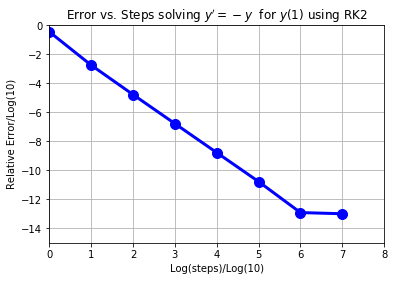

In [30]:
plt.plot(np.log(steps)/np.log(10),np.log(rel_error)/np.log(10), color='blue', marker='o', linestyle='solid', linewidth=3, markersize=10) 

plt.axis([0,8,-15,0])
plt.title("Error vs. Steps solving $y' = -y$  for $y(1)$ using RK2")
plt.xlabel("Log(steps)/Log(10)")
plt.ylabel("Relative Error/Log(10)")
plt.grid(True)
# plt.savefig("figure.png") #save the plot to a file
plt.show()

* Initially, decreasing stepsize by an order of magnitude decreases 

* Slope $\approx -2 \implies$ second order global truncation error

* Error plateau indicates roundoff error becoming significant

# START HERE THURSDAY 1/30/20

## Section 7.2 - Error Analysis for Time-Stepping Routines

### Explicit methods vs. Implicit methods

Earlier in this notebook we considered solving a first order system of ODs  
$$\frac{d \boldsymbol{y}}{dt} = f(\boldsymbol{y}, t)$$

using Euler's method $$y_{n+1} = y_n + h f(t_n, y_n)$$

In our implementation of and experimentation with this method, we have noted a few relevant properties:

1) Like all discretization methods, this method converts the given __differential equation__ (with a __continuously valued independent variable__) to a __difference equation__ (where the independent variable is replaced by an index value that takes on __discrete values__) The equation for computing the dependent value(s) $\boldsymbol{y}_{n+1}$ at the next discrete value of the idependent variable $t_{n+1}$ is often referred to as an __iteration formula__.

2) This is an __explicit method__ because the iteration formula specifies $\boldsymbol{y}_{n+1}$ as an explicit function of values at $t_n$; i.e. $\boldsymbol{y}_{n+1}$ is isolated on the left side of the formula and does not appear on the right side of the formula. Using more specific language, this is the __explicit Euler method__ or __forward Euler method__.

3) The explicit Euler method exhibits $1^{st}$-order global truncation error (associated with $2^{nd}$-order local truncation error).

4) The explicit Euler method can exhibit __instability__ if the stepsize is allowed to become too large (in relation to the rates of change)

5) The explicit Euler method was obtained using a $2^{nd}$-order forward difference to estimate the derivative at the beginning (left edge) of the step.

Now let's consider an alternative approach and estimate the derivative at the end (right edge) of the step using the corresponding __backward difference__ estimate:

Instead of $y'(t_n) = \frac{1}{h} (y_{n+1}-y_n)$, use $y'(t_{n+1}) = \frac{1}{h} (y_{n+1}-y_n)$ to obtain:
$$y_{n+1} = y_n + h f(t_n, y_{n+1})$$

This iteration formula specifies $y_{n+1}$ __implicitly__ (because $y_{n+1}$ no longer appears as an isolated term, but appears in multiple terms in the iteration formula). This is called the __implicit Euler method__ or __backward Euler method__.

In general, this would involve using a solver or rootfinding technique at each step (which would be expensive and, therefore, undesirable). Before coming back to a general fix to address this issue, let's return to our example problem: $$y' = f(y,t) = \lambda y \; ; \; y(0)=y_0$$ 

Due to the simple form of the rate specification, $f(u,t) =  - \lambda y$, we can obtain an explicit iteration formula describing the approximate solution obtained using the implicit Euler method:
$$y_{n+1} = y_n + h f(t_n, y_{n+1}) = y_n + h \lambda y_{n+1} \implies (1-\lambda h) y_{n+1} = y_n$$
or $$y_{n+1} = \frac{1}{1-\lambda h} y_n$$
We can solve this difference equation to obtain the implicit euler solution: $$y_N = y_0 \big( \frac{1}{1-\lambda h} \big)^N$$
Compare this with the explicit Euler method: 
$$y_{n+1} = (1+\lambda h) y_n \implies y_N = y_0 (1+\lambda h)^N$$

In each case, we obtain a solution as a geometric sequence. Each iterate is a multiple of the previous iterate, so the solutions of the difference equations exhibit growth or decay depending on the magnitude of the multiplicative factor. 

The solution (and the error in the solution) decays when the factor has magnitude $<1$.

The solution (and the error in the solution) grows implying __instability__ when the factor has magnitude $>1$.

So let's obtain a __stability criterion__ for each method (corresponding to the multiplier having magnitude $<1$). For larger systems, the multiplier arises as an eigenvalue (which can be complex), so the common notation is to write $$\lambda h =z$$ and to think of $z$ as a complex variable (even though, in this simple case, we will be interested in what happens along the real axis).

- The stability criterion for the explicit Euler method, where the multiplicative factor is $(1+z)$, is:
$$\big| 1+z \big| < 1$$

- The stability criterion for the implicit Euler method, where the multiplicative factor is $(1-z)^{-1}$, is:
$$\big| \frac{1}{1-z} \big| < 1$$

Let's plot the stable regions:

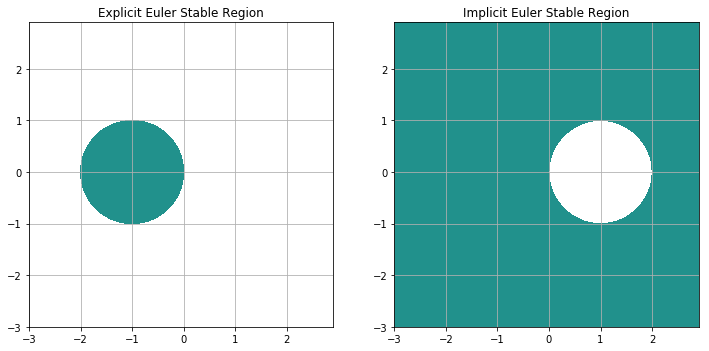

In [364]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)

X, Y = np.meshgrid(x, y)

Z1 = np.sqrt((X+1)**2 + Y**2)
Z2 = 1./np.sqrt((X-1)**2 + Y**2)
levels = [0.,1.]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

mycmap1 = plt.get_cmap('gist_earth')
ax1.set_aspect('equal')
ax1.set_title('Explicit Euler Stable Region')
ax1.grid()
cf1 = ax1.contourf(X,Y,Z1, levels)

mycmap2 = plt.get_cmap('gnuplot2')
ax2.set_aspect('equal')
ax2.set_title('Implicit Euler Stable Region')
ax2.grid()
cf2 = ax2.contourf(X,Y,Z2, levels)

plt.show()

Now interpret the results (focusing on the real axis):

Explicit Euler is stable when $-2 < \lambda h < 0$, so for the interesting case when $\lambda <0$ (when the solution itself is stable), a stable Explicit Euler solution requires $$h < \frac{2}{\lambda}.$$

Implicit Euler is stable except when $0 < \lambda h < 2$, so for the interesting case when $\lambda <0$ (when the solution itself is stable), a stable Implicit Euler numerical solution is obtained for all stepsizes.$$

As an example, let's return to the sample problem $y' =  -25y$ (where $\lambda = 25$).

We saw that the explict Euler solution was stable for $h = 0.02$ and unstable for $h =  0.1$. We can now pinpoint the cutoff point between stable and unstable solutions should occur at $h = \frac{2}{25} = 0.08$.

In sharp contrast, the implicit Euler method continues to be stable for large stepsize (although with gradual loss of accuracy).

The enhanced stability makes the implicit approach seem attractive, but remember that there is an associated cost: in general, an implicit approach would require using rootfinding to compute the new dependent value that satisfies the iteration formula. It is only is very simple cases where an implicit method leads to an iteration formula that can be converted to explicit form.

This has led to a middle ground approach:

- Use an explicit method to compute a __predicted__ value for $y_{n+1}$

- Then use an implicit method, plugging the predicted value in the rate equation, to compute a __corrected__ value for $y_{n+1}$.

Such an approach is called a __predictor-corrector__ method. More specifically, the scheme above is a __predict-evaluate-correct (PEC)__ approach.

Solving an ODE involves estimating a solution based on a given rate of change. and the predictor-corrector approach can be thought of as an attempt to carry forward information about how the value is changing. (Note that Runge-Kutta methods compute a new value and then immediately ignore all the old values.) In that context, it is natural to consider predictor-corrector schemes based on __multi-step methods__ such as the Adams method that was mentioned above, but not yet implemented:

$$y_{n+1}=y_n + \frac{h}{2} \big[ 3 f(t_n,y_n) - f(t_{n-1},y_{n-1}) \big]; \qquad \mathrm{Eq.(7.1.23)}$$

Recall that this formula was obtained by constructing a degree $n$ interpolant based on the current value and values from the $n$ previous steps. In this particular case, $n=1$ and this is called the __second order Adams-Bashforth method__, and it provides an __explicit__ formula for computing $y_{n+1}$.

In very much the same way, we could construct the interpolant based on values at the current step, the next step, and $n-1$ previous steps. This leads to an __implicit__ formula called the __Adams-Moulton method__. The second order Adams-Moulton formula is:
$$y_{n+1}=y_n + \frac{h}{2} \big[ f(t_{n+1},y_{n+1}) + f(t_n,y_n)  \big]$$

Instead of rootfinding to solve for $y_{n+1}$ in the Adams-Moulton formula, pair it with the corresponding Adams-Bashforth method:

- Use the explicit Adams-Bashforth method to compute a predicted value $y^P_{n+1}$

- Plug the prediction into the right-hand side of the implicit Adams-Moulton formula

\begin{equation}
\begin{aligned}
y^P_{n+1}&=y_n + \frac{h}{2} \big[ 3 f(t_n,y_n) - f(t_{n-1},y_{n-1}) \big]; \qquad \mathrm{Eq.(7.1.29)} \\
y_{n+1}&=y_n + \frac{h}{2} \big[ \; f(t_{n+1},y^P_{n+1}) + f(t_n,y_n)  \big]
\end{aligned}
\end{equation}

Together the equations provide a way to employ an implicit method without the expense of solving nonlinear equations.

__Comment for ME535 Winter 2020__: You should implement the Adams-Bashforth-Moulton method as part of Homework 3.

## Section 7.3 - Advanced Time-Stepping Algorithms

Please read this section on your own.

## Section 7.4 - Boundary Value Problems: <br>The Shooting Method

__ME535 W2020 Note: Start here Tuesday 2/4/20__

So far, we have dealt with __initial value problems (IVPs)__ where the given values are at some initial "time" and we can step forward from there to wherever the solution takes us. Now we consider __boundary value problems (BVPs)__ where conditions are specified at the endpoints of an interval. For example, a typical second order boundary value problem has the form:
$$\frac{d^2 y}{dt^2} = f \big(t, y, \frac{dy}{dt} \big)$$
with boundary conditions
\begin{equation} \label{eq1}
\begin{split}
\alpha_1 y(a) + \beta_1 \frac{dy(a)}{dt} & = \gamma_1 \\
\alpha_2 y(b) + \beta_2 \frac{dy(b)}{dt} & = \gamma_2
\end{split}
\end{equation}

### The shooting method

One approach to such a problem is a shooting method:

- Satisfy the condition at one end of the interval and guess the other condition that should be satisfied there.

- Apply one of the stepping methods we have developed to get a numerical solution at the other end of the interval.

- Based on the "residual" (how far the solution is from satisfying the second condition), adjust the guess.

- Repeat until tolerance is satisfied.

To be more concrete, consider the basic case where the boundary conditions are $$y(a) = \alpha ; y(b) = \beta$$.

(This notation is not exactly self-consistent, but it consistent with the text.)

As usual, we convert the second order ODE to a first order system in term of the vector $$\boldsymbol{y} = (y, \frac{dy}{dt})^T = (y_0, y_1)^T$$

So we have an initial value of `y[0]`$=y$ at $t=a$, and we have to determine the initial value of the velocity `y[1]` at $t=a$: $$\frac{dy(a)}{dt} = A$$.

After some initial exploring to find values $A_1$ that produces a value $y(b)<\beta$ and $A_2$ that produces a value $y(b)>\beta$, than applying a bisection rootfinding method can be applied to find $A^*$ that leads to $|y(b)-\beta| <$ tolerance.

$$ \frac{d^2y}{dt^2} = f \bigg( t, y, \frac{dy}{dt} \bigg)$$
$$ \alpha_1 y(a) + \beta_1 \frac{dy(a)}{dt} = \gamma_1$$
$$ \alpha_2 y(b) + \beta_2 \frac{dy(b)}{dt} = \gamma_2$$

### Example Problem
Here is an implementation of the shooting method example from pp. 156-7 in Kutz.
$$y'' + (x^2 - sin \space x)y' - (cos^2\space x)y = 5 \qquad x \in [0,1]$$
$$ y(0)=3;\quad y'(1)=5 $$

#### Apply procedure:

1. Rearrange ODE with highest order derivative by itself: $\frac{dy_N}{dt}=RHS$
1. Replace every solitary independent variable on $RHS$ with $y_0$
2. Replace every n-th order derivative on $RHS$ with $y_n$
3. Write $f(\boldsymbol{y},t) = \frac{d\boldsymbol{y}}{dt} = \frac{d}{dt} \begin{pmatrix} y_0\\y_1\\\vdots\\y_N \end{pmatrix}= \begin{pmatrix} y_1\\y_2\\ \vdots\\\ RHS \end{pmatrix}$

__Application__:

1. $y'' = RHS = (cos^2\space x)y - (x^2 - sin \space x)y' + 5$
2. $RHS = (cos^2\space x)y_0 - (x^2 - sin \space x)y_1 + 5$
3. $f(\boldsymbol{y},t) = \frac{d\boldsymbol{y}}{dt} = \frac{d}{dt} \begin{pmatrix} y_0\\y_1 \end{pmatrix} = \begin{pmatrix} y_1\\(cos^2\space x)y_0 - (x^2 - sin \space x)y_1 + 5 \end{pmatrix}; \quad y_0(0)=3,\quad y_1(1) = 5$

In [863]:
# Notice to how this mimics f(y,t), but instead of t we have x
def bvpexam_rhs(x,y):
    return np.array([y[1], 
                    (np.cos(x))**2*y[0] - (x**2-np.sin(x))*y[1] + 5],dtype=np.float64)

xspan = np.array([0, 1],dtype=np.float64) # Span over which we are considering the problem
A = -3; dA = 0.5; # Initial guess at A, which is our intial y_1

for j in range(1000):
    y = np.array([3, A],dtype=np.float64) # initial values for [y_0, y_1]
    sol = integrate.solve_ivp(bvpexam_rhs,xspan,y,max_step=0.01)

    if j==0: #save the results of the first A value for comparison to final result
        init_y = np.copy(sol.y.T)
        init_t = np.copy(sol.t)
    
    if np.abs(sol.y.T[-1,1] - 5) < 1e-6: # Checking to see if our final y_1 is equal to 5 (the boundary condition we care about)
        break
    
    if sol.y.T[-1,1]<5: 
        A+=dA
    else:
        A -= dA
        dA *= 0.5

print("Ran in {} iterations".format(j+1))

Ran in 41 iterations


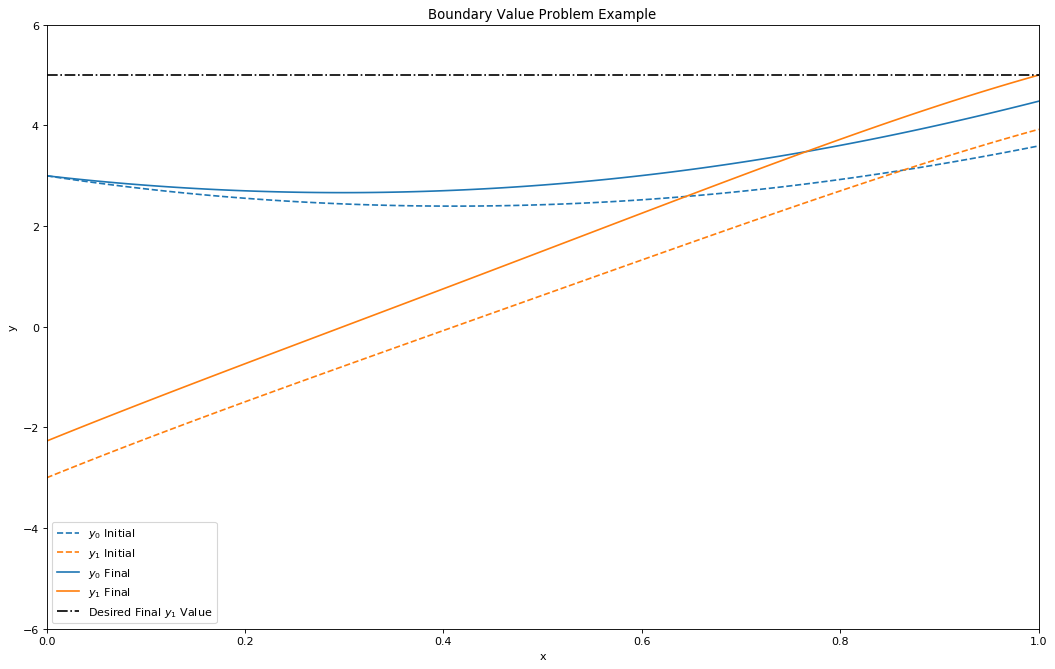

In [864]:
fig, ax = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)
ax.plot(init_t,init_y[:,0],'--')
ax.plot(init_t,init_y[:,1],'--')
plt.gca().set_prop_cycle(None) # resets colors
ax.plot(sol.t,sol.y.T[:,0])
ax.plot(sol.t,sol.y.T[:,1])
ax.plot([0, 1],[5, 5],'k-.')
ax.set(xlim=(0,1),ylim=(-6,6),xlabel="x",ylabel="y",title="Boundary Value Problem Example")
legend_str = ["$y_0$ Initial", "$y_1$ Initial","$y_0$ Final", "$y_1$ Final","Desired Final $y_1$ Value"];
plt.legend(legend_str);

### Eigenvalues and eigenfunctions <br>(and the infinite domain)

Boundary value problems often arise as eigenproblems where both the eigenvalue and eigenfunction must be determined. For example:
$$\frac{d^2\psi_n}{dx^2} + [n(x)-\beta_n]\psi_n = 0$$
with boundary conditions $$\psi_n(x) \rightarrow 0 \; \mathrm{as} \; x\rightarrow \pm \infty$$

This is essentially the Shrodinger equation with potential well $n(x)$. While the domain here is infinite, our stepping methods require that we compute on a finite domain, so we will consider $x\in [-L,L]$ for some finite value of $L$. The example in the book considers $n(x)$ with __finite support__ ("support" is the region where the function can have non-zero values):
$$n(x) = n_0 (1-|x|^2)\; \mathrm{on} \; -1 \leq x \leq 1 ; \qquad n(x)=0 \; \mathrm{elsewhere}$$

Beyond the support region the ODE simplifies to: $$\frac{d^2\psi_n}{dx^2} - \beta_n\psi_n = 0$$
which we can solve analytically: $$\psi_n = c_1 \mathrm{exp}\big(\sqrt{\beta_n} x \big) + c_2 \mathrm{exp}\big(-\sqrt{\beta_n} x \big)$$
Applying the BCs $\psi_n \rightarrow 0$ as $x\rightarrow \pm \infty$, we get left side and right side solutions:
$$\psi_n = c_2 \mathrm{exp}\big(-\sqrt{\beta_n} x \big), \qquad x>1$$ 
$$\psi_n = c_1 \mathrm{exp}\big(\sqrt{\beta_n} x \big), \qquad x<-1$$

From there, we can obtain conditions at $x= \pm 1$:
$$\frac{d \psi_n(1)}{dx} = -\sqrt{\beta_n} \psi_n(1)$$
$$\frac{d \psi_n(-1)}{dx} = \sqrt{\beta_n} \psi_n(-1)$$

Now we convert to a first order system to arrive at the boundary value problem:
\begin{equation} \label{eq1}
\begin{split}
y_0' &= \psi_n' & = y_1 \\
y_1' &= \psi_n'' & = [\beta_n-n(x)] y_0
\end{split}
\end{equation}

with BCs: 
\begin{equation} \label{eq1}
\begin{split}
x=1 &: y_1 & = -\sqrt{\beta_n} y_0 \\
x=-1 &:  y_1 & = \sqrt{\beta_n} y_0
\end{split}
\end{equation}

This is the sort of BVP that can be solved using a shooting method where we search for the eigenvalue that appears in the boundary conditions; i.e. by adjusting $\beta$ and looking for a sign change in the relevant boundary condition.

Kutz' Fig. 7.9 illustrates the first 4 eigenvalues and corresponding eigenfunctions for this problem. Before we attempt to implement this problem, let's start with something a bit more straightforward.

## Section 7.5 - Implementation of Shooting and Convergence Studies

Let's start with the "constant potential" case where $n(x) = n_0$ for $|x|<1$ and $x=0$ elsewhere.
Choosing the length unit so that $L=1$, the problem becomes:
$$\frac{d^2\psi_n}{dx^2} - \beta_n\psi_n = 0$$
with boundary conditions $$\psi(-1)=0, \; \psi(1)=0$$
You should know how to do some things with this system:

1) Write the analytic solution once you know an eigenvalue.

2) Write an equation that you can solve for the eigenvalues using a rootfinding technique. 

That said, let's see what happens if we apply a numerical ODE solver with a shooting technique where we use the conditions $$y(-1)=0, \; y'(-1)=A$$ to create and IVP so we can use a stepping method to compute $y(1)$. 

In fact, since this problem is linear, we can choose the scale ($y \rightarrow y/A$) so that $y'(-1)=1$. Shooting to find a solution with $|y_n(1)| < tol$ then becomes a matter of finding an approapriate value $\beta = \beta_n$.

The plan is to start with the largest reasonable value $\beta = n_0$ (above which the solutions of the ODE diverge), solve the ODE, check the value at $x=1$, and adjust or refine as approopriate. Note that the parity of the eigenfunction comes into play here: For even modes, $y(1) . 0$ implies that $\beta$ needs to increase to decrease $|y(1)]$ while the opposite is true for odd modes. With that in mind, let's check out the implementation below that aims to find the first 4 modes:

In [865]:
tol = 1e-4 # define a tolerance level to be achieved by the shooting algorithm
colors=['r','b','g','c','m','k'] # eigenfunction colors to be used in plotting routine

n0 = 100    # define parameter n0
A = 1       # define initial slope at x=-1
y0 = np.array([0, A],dtype=np.float64)  # initial conditions: x1(-1)=0, x1'(-1)=A
L = 1
xspan = np.array(L*[-1, 1],dtype=np.float64) # define the span of the computational domain
num_steps = 100
xstep = (xspan[1]-xspan[0])/num_steps

In [866]:
#define the function that gives the rates of change for the linear system
def shoot2(xspan,x,n0,beta):
    return np.array([x[1], (beta-n0)*x[0]],dtype=np.float64)
shoot2(xspan,y0,100,100)

array([1., 0.])

Beta Value: 97.53271484375
Beta Value: 90.12998046875
Beta Value: 77.79560546875001
Beta Value: 60.52373046875002
Beta Value: 38.314355468750016


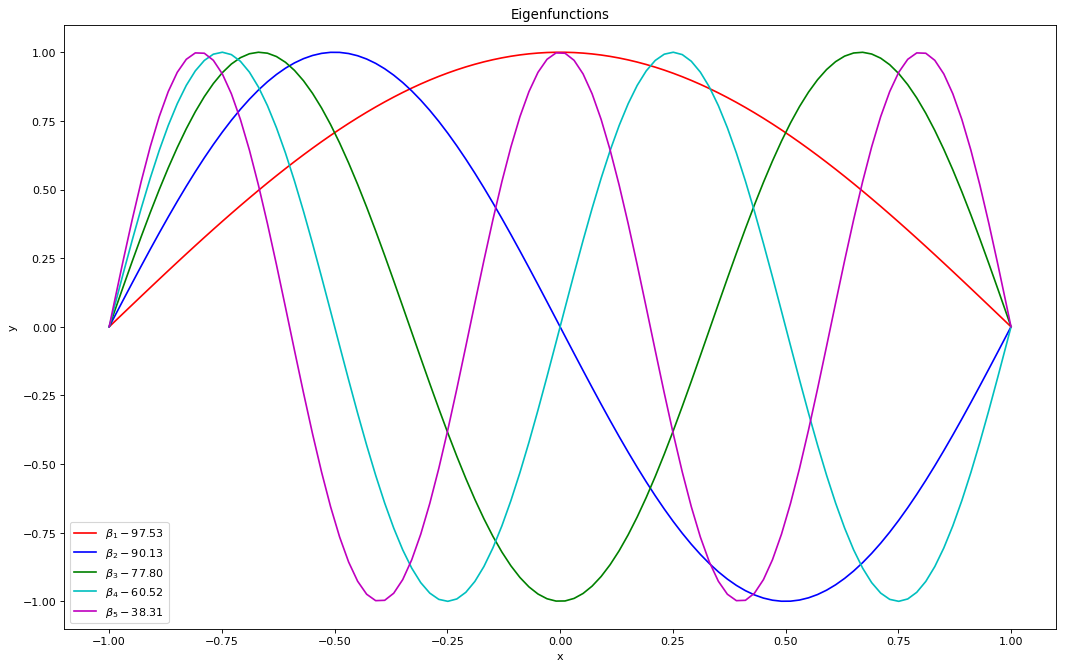

In [867]:
fig, ax = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)

beta_start = n0     # beginning value of beta
betas = np.zeros((5,))
for modes in range(5):  # begin mode loop
    beta = beta_start   # initial value of eigenvalue beta
    dbeta = n0/100      # default step size in beta
    for m in range(1000):   # begin convergence loop for beta
        # Scipy v1.4.1 supports args tuple similar to how MATLAB handles arguments for the evaluated function
        # sol = integrate.solve_ivp(shoot2,xp,x0,args=(n0, beta))
        # I have not tested the above function call
        # Scipy v1.3.1 requires us to rewrite our shoot2 function as a lambda function and pass in the arguments directly
        # sol = integrate.solve_ivp(lambda xp,x0 : shoot2(xp,x0,n0,beta),xspan,y0,max_step=xstep,method='RK45')
        sol = integrate.solve_ivp(lambda xp, x : np.array([x[1], (beta-n0)*x[0]]),xspan,y0,max_step=xstep,method='RK45')
        y = sol.y
        t = sol.t
        if np.abs(y[0,-1]-0) < tol: #if y(1) is found within tolerance, print and save the value and break out of loop
            print("Beta Value:",beta)
            betas[modes] = beta;
            break
        if (-1)**modes * y[0,-1] > 0:#if y(1) is positive/negative, decrease beta (increase frequency) for even/odd modes
            beta -= dbeta
        else: # oterwise the beta value is too small, so bisect (increase by half the previous increment)
            beta += dbeta/2
            dbeta *= 0.5
    beta_start=beta-0.1 #after finding a mode, decrease the starting value for finding the next mode
    norm = np.trapz(y[0,:]*y[0,:],x=t) #compute the integral of y**2 for normalization
    ax.plot(t,y[0,:]/np.sqrt(norm),colors[modes]) #normalize and plot

ax.set(title="Eigenfunctions",xlabel="x",ylabel="y");
legend_str = ('$\\beta_{} - {:2.2f}$'.format(n,b) for n,b in enumerate(betas,1))
plt.legend(list(legend_str));


We will return to consider the more challenging problem with the quadratic potential. 

For now, let's push ahead to discuss alternatives to the shooting method.

## Section 7.6 - Boundary Value Problems:<br>Direct Solve and Relaxation




Let's start by considering a particular type of second order boundary value problem (__$2^{nd}$-order BVP__): computing solutions for second-order linear ODEs with variable coefficients subject to __Dirichlet boundary conditions__ (where the value of the function is given as opposed __Neumann BCs__ where the value of the derivative is given). The generic problem of this type is of the form:
$$ \frac{d^2y}{dt^2} = p(t) \frac{dy}{dt} + q(t) y + r(t)$$
$$y(a) = \alpha \; ; \; y(b) = \beta$$

Onxe again, floating point arithmetic does not support derivatives (whose deinitions involve a limit as $\Delta t \rightarrow 0$) we discretize the independent variable $t$ and seek to compute values of the dependent variable at the discrete $t$ values. Instead of doing this by writing a _recursion relation_ (or _difference equation_ or _iteration formula_) that can be used to sequentially find the next value based on earlier known values, we now consider all the discrete values together in a single system to be solved simultaneously. 

Let's start simply with a uniform spacing or stepsize between the discrete time values:
$$t_n = a + n \Delta t \; ; \; t_0 = a \; ; \; t_N = b \; ; \; \Delta t = \frac{b-a}{N}$$
so we are looking to solve for $y_n = y(t_n) , n \in [1,N-1]$.

Now approximate the derivatives using one of the finite difference estimators from Ch. 4. In particular, let's use the lowest (second) order central difference estimators for the $1^{st}$ abd $2^{nd}$ derivatives:
$$\frac{dy(t)}{dt} = \frac{y_{n+1} - y_{n-1}}{2 \Delta t}$$
$$\frac{d^2y(t)}{dt^2} = \frac{y_{n+1} - 2 y_n + y_{n-1}}{\Delta t^2}$$

Substituting the central difference expressions into the ODE gives:
$$\frac{y_{n+1} - 2 y_n + y_{n-1}}{\Delta t^2}=p(t_n) \frac{y_{n+1} - y_{n-1}}{2 \Delta t}+q(t_n)y_n+r(t_n)$$

It is convenient to collect terms where $y$ has a common subscript:
$$\big[ 1+\frac{\Delta t}{2}p(t_n) \big] y_{n-1} - \big[2+\Delta t^2 q(t_n) \big] y_n +\big[ 1-\frac{\Delta t}{2}p(t_n) \big] y_{n+1} = \Delta t^2 r(t_n)$$.


This gives us a discretized equation for each of the "internal nodes", $n \in [1,N-1]$, and we can put them together into a system of equations to solve for the unknown values of the dependent variable. Here we started with a linear ODE, so we produce a linear system of the usual form $A \boldsymbol{y} = \boldsymbol{b}$ where:

\begin{equation}
A = \begin{bmatrix}
2+\Delta t^2 q(t_1) & -1+\frac{\Delta t}{2}p(t_1) & 0 & \cdots & & & 0 \\
-1-\frac{\Delta t}{2}p(t_2) & 2+\Delta t^2 q(t_2) & -1+\frac{\Delta t}{2}p(t_2) & 0 & \cdots & & 0 \\
0 & \ddots & \ddots & \ddots  & & & 0 \\
\vdots &&&&&& \vdots\\
&&&&&& 0 \\
\vdots &&&& \ddots & \ddots & -1-\frac{\Delta t}{2}p(t_{N-2}) \\
0 & \cdots & & & 0 & -1-\frac{\Delta t}{2}p(t_{N-1}) & 2+\Delta t^2 q(t_{N-1}) 
\end{bmatrix}
\end{equation}

with 

\begin{equation}
\boldsymbol{y} =
\begin{bmatrix}
   y(t_1)   \\
   y(t_2)   \\
   \vdots \\
   y(t_{N-2})   \\
   y(t_{N-1})  
\end{bmatrix}
\qquad \boldsymbol{b} = 
\begin{bmatrix}
    -\Delta t^2r(t_1)+(1+\Delta t p(t_1)/2)y(t_0)   \\
   -\Delta t^2 r(t_2)   \\
   \vdots \\
   -\Delta t^2 r(t_{N-2})   \\
   -\Delta t^2r(t_{N-1})+(1+\Delta t p(t_{N-1})/2)y(t_N)      
\end{bmatrix} 
\end{equation}

Let's use this approach to recreate the eigenvalues and eigenfunctions for the Shrodinger equation with constant potential.
$$\frac{d^2\psi}{dx^2}+n_0 \psi = \beta \psi \implies p(x)=r(x)=0, \; q(x)=\beta-n_0$$

In [1236]:
from scipy.sparse import diags
n = 100
L = 1
x = np.linspace(-L,L,n+2)
dx = (2*L)/(n+1)
print(dx)
b = x[1:-1]
b1 = diags([1, -2, 1], [-1, 0, 1], shape=(n,n)).toarray()
d =  100*np.eye(n) #np.diag(b*b) #100*np.eye(n)
m = (1/dx**2)*b1+d
#print(m)

0.019801980198019802


In [1237]:
from numpy import linalg as LA
vals,vecs = LA.eigh(m)
vals

array([-10098.53, -10091.13, -10078.81, -10061.57, -10039.44, -10012.43,
        -9980.57,  -9943.9 ,  -9902.44,  -9856.24,  -9805.35,  -9749.8 ,
        -9689.66,  -9624.98,  -9555.83,  -9482.28,  -9404.38,  -9322.23,
        -9235.89,  -9145.46,  -9051.02,  -8952.66,  -8850.47,  -8744.57,
        -8635.03,  -8521.99,  -8405.53,  -8285.79,  -8162.86,  -8036.87,
        -7907.95,  -7776.21,  -7641.79,  -7504.82,  -7365.42,  -7223.73,
        -7079.89,  -6934.04,  -6786.32,  -6636.87,  -6485.84,  -6333.37,
        -6179.61,  -6024.72,  -5868.83,  -5712.1 ,  -5554.68,  -5396.73,
        -5238.39,  -5079.82,  -4921.18,  -4762.61,  -4604.27,  -4446.32,
        -4288.9 ,  -4132.17,  -3976.28,  -3821.39,  -3667.63,  -3515.16,
        -3364.13,  -3214.68,  -3066.96,  -2921.11,  -2777.27,  -2635.58,
        -2496.18,  -2359.21,  -2224.79,  -2093.05,  -1964.13,  -1838.14,
        -1715.21,  -1595.47,  -1479.01,  -1365.97,  -1256.43,  -1150.53,
        -1048.34,   -949.98,   -855.54,   -765.11, 

[60.57 77.81 90.13 97.53]


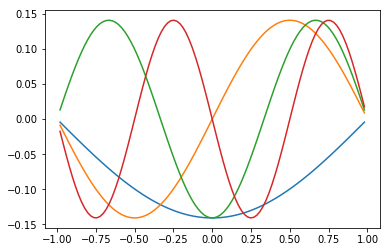

In [1238]:
print(vals[-4:])
plt.plot(b,vecs.T[-1])
plt.plot(b,vecs.T[-2])
plt.plot(b,vecs.T[-3])
plt.plot(b,vecs.T[-4])
plt.show()

The curves do not start and end with value zero because we are only plotting the solution for the internal points. To get the full mode shape we can write a `pad` function to include a `0` at each end of the array, and plot vs.`t` (which is a `linspace` over the full domain):

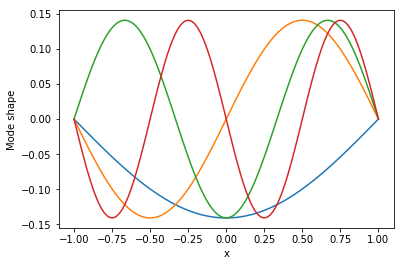

In [1264]:
def pad(a):
    return np.concatenate(([0],a,[0]))

plt.plot(x,pad(vecs.T[-1]))
plt.plot(x,pad(vecs.T[-2]))
plt.plot(x,pad(vecs.T[-3]))
plt.plot(x,pad(vecs.T[-4]))
plt.xlabel("x")
plt.ylabel("Mode shape")
plt.show()

So the __direct solve__ method worked nicely to compute the modes of this linear ODE.

We can take a similar approach with nonlinear ODEs, but we end up having to solve a large system of nonlinear equations which is a challenging problem in its own right.

__ME535 W2020 note:__ We will return to this later if time allows.

# Return to the eigenproblem with quadratic potential

### Start by naively applying our previous code

As suggested in the text, run some individual solutions to see how the solutions behave before trying to automate the shooting method to find the eigenvalues and eigenfunctions. Here we start using our Runge-Kutta code to search the range of $\beta$ around the expected first eigenvalue ($\beta_1 = 86.79$) to see how solutions behave.

We will apply initial conditions: $$y(-1)= 1 ; \; y'(-1) = \sqrt{\beta}$$ and search for values of $\beta$ that produce solutions that satisfy the right boundary condition to within a specified tolerance: $$ \big| \, y'(1)+\sqrt{\beta} y(1) \, \big| < tol $$

Below we run the simulation using our Runge-Kutta code and look at the evolution of the quantity of interest that should vanish at the right end of the interval:

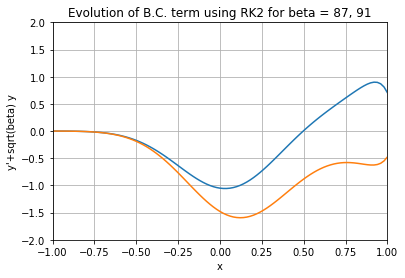

In [1245]:
num_steps = 100 #set number of integration steps
tvals = L*np.linspace(-1,1,num_steps+1) #create array of discrete times

def n(x, n0):
    return max(0,n0*(1-x**2))
        
def psi_rates(y,x):
    rates = np.array([y[1], (beta - n(x,n0))*y[0] ])
    return rates

for beta in (87, 91):
    y0 = np.array([1,np.sqrt(beta)])
    sol = rk_solve(psi_rates, y0,tvals)
    y =  sol.T
    plt.plot(tvals, (y[1]-np.sqrt(beta)*y[0])/1e3)

plt.title("Evolution of B.C. term using RK2 for beta = 87, 91")
plt.xlabel("x")
plt.ylabel("y'+sqrt(beta) y")
plt.grid(True)
plt.axis([-1,1,-2,2])
plt.show()

So this looks like it might be promising because the value at $x=1$ does change over the interval $\beta \in [87,91]$ where the first eigenvalus is expected. However, there are also signs of potential trouble:

- The problem has symmetry about $x=0$, but the numerical solutions do not show symmetry.

- The numerical solutions show some suspicious "wiggles" near the right end of the domain.

So let's back up and look at the solutions themselves:

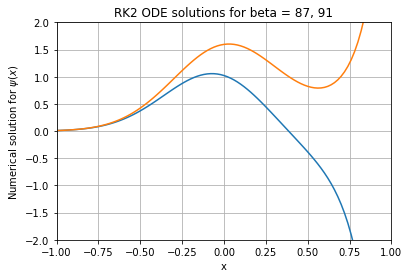

In [1247]:
tvals = L*np.linspace(-1,1,num_steps+1)
for beta in (87, 91):
    y0 = np.array([1,np.sqrt(beta)])
    sol = rk_solve(psi_rates, y0,tvals)
    y =  sol.T
    plt.plot(tvals,y[0]/1e2)
plt.title("RK2 ODE solutions for beta = 87, 91")
plt.xlabel("x")
plt.ylabel("Numerical solution for $\psi(x)$")
plt.grid(True)
plt.axis([-1,1,-2,2])
plt.show()

This does not look good. The solutions are diverging and some instability has arisen. To check if this is an artifact of our solver, let's compare with results from the standard library solver `scipy.integrate.solve_ivp` using a completely different method, `BDF`, a variable-order implicit multi-step. method:

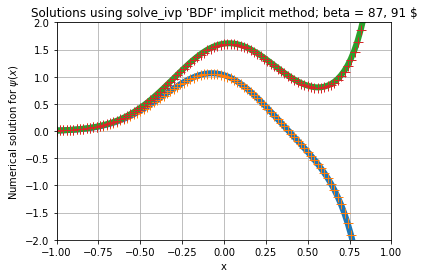

In [1258]:
xspan = np.array([-1,1])
for beta in (87, 91):
    y0 = np.array([1,np.sqrt(beta)])
    sol = integrate.solve_ivp(
        lambda x, y : np.array([y[1], (beta-n0*(1-x*x))*y[0]]),
        xspan,y0,max_step=xstep,method='BDF')
    y = sol.y
    t = sol.t

    plt.plot(t,y[0]/1e2, linewidth=6)
    
    sol = rk_solve(psi_rates, y0,tvals)
    y =  sol.T
    plt.plot(tvals,y[0]/1e2, linestyle='', marker='+', markersize=10)
    
plt.title("Solutions using solve_ivp 'BDF' implicit method; beta = 87, 91 $")
plt.xlabel("x")
plt.ylabel("Numerical solution for $\psi(x)$")
plt.grid(True)
plt.axis([-1,1,-2,2])
plt.show()

The plot above shows the implicit solutions (solid) and the RK2 solutions (+). The solutions from these 2 very different algorithms are very close, and the large-scale divergent behavior does not seem to be a solver artifact. 

__ASIDE: Discuss how to show that functions agree! (and how not to...) __

*All too often, you will see a figure with 2 plots that appear to be a single curve, and the text will say something like: "You can see that the results are so close that these 2 results agree." However, you cannot really see that. Plotting with different styles (so that both are visible) or plotting the difference can provide ___visible___ evidence of agreement.*

This example nicely illustrates that it pays to maintain a healthy skepticism and to think carefully before accepting numerical results at face value. Before believing your solution you should:

- Test for sensitivity to stepsize.

- Test for sensitivity to algorithm.

- Bring to bear what you know about the problem (in a mathematical or physical sense).

Think carefully about this problem, and try to account for what is happening.<br><br><br><br><br><br><br><br><br>
When the coefficient $[n(x)-\beta]$ is positive, the solutions are sinusoidal (or exponential with imaginary exponents) and the numerical solutions are reasonably behaved. 

But, for $|x| > \sqrt{\beta/n_0}$, $[n(x)-\beta]$ becomes negative $\implies$:

- Solutions behave like exponentials with REAL exponents.

- Exponential decay and growth. 

As $x \rightarrow \pm \infty$, we made an analytical argument to:

- Force the coefficient of the growing exponential to vanish. 

- Suppress the divergence.

Suppressing a growing component in a numerical solution is not so easy: 

- There will always be roundoff error.

- Generically re-introduce exponential growth.

- Eventually cause divergence.

So what can we do here? <br><br><br><br><br><br><br><br><br><br>

Restrict the computation to the "computable" region where the coefficient is positive $\implies$ $x \in [-L,L]$ where $L = \sqrt{1- \beta/n_0}$.

What boundary condition would we check for at $L$?

Better yet, compute on $[-L,0]$ and use symmetry $\implies y'(0)=0 \; \text{(even modes)} ;\quad y(0)=0 \; \text{(odd modes)}$

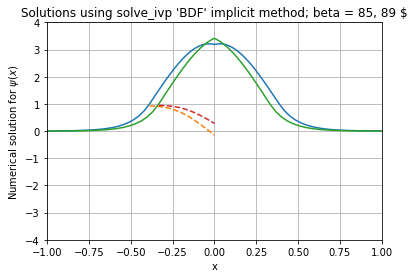

In [1306]:
# even mode
for beta in (85, 89):
    y0 = np.array([1,np.sqrt(beta)])
    L = np.sqrt(1-beta/n0)
    xspan = L*np.array([-1,0])
    exp_span = np.linspace(-1,-L, 20) #left exponential domain
    exp_vals = np.exp(np.sqrt(beta)*(exp_span+L)) #left exponential values
    #run ODE solver on [-L,0]
    sol = integrate.solve_ivp(
        lambda x, y : np.array([y[1], (beta-n0*(1-x*x))*y[0]]),
        xspan,y0,max_step=xstep,method='BDF')
    y = sol.y
    t = sol.t
    # concatenate left expoential with numerics to assemble half the solution 
    half_span = np.concatenate([exp_span,t])
    half_vals = np.concatenate([exp_vals,y[0]])
    # concatenate these with their mirror images to assemble complete solution 
    complete_span = np.concatenate([half_span, np.flipud(-half_span)])
    complete_vals = np.concatenate([half_vals, np.flipud(half_vals)])
    
    plt.plot(complete_span, complete_vals) #plot the mode
    plt.plot(t, y[1]/1e1, linestyle="dashed") #plot derivative
  
plt.title("Solutions using solve_ivp 'BDF' implicit method; beta = 85, 89 $")
plt.xlabel("x")
plt.ylabel("Numerical solution for $\psi(x)$")
plt.grid(True)
plt.axis([-1,1,-4,4])
plt.show()

The dashed lines show a multiple of the derivative computed by the ODE solver, and the plots show a change insign indicating the presence of an eigenvalue in the interval $\beta \in [85,89]$. The solutions (shown with solid lines) are not quite smooth ($y'(0) \neq 0$), but bisection can be employed to compute approximations of the eigenvalue and the associated smooth eigenfunction (as illustrated below).

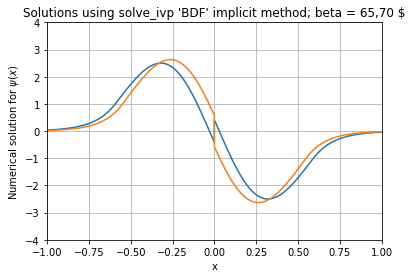

In [1309]:
#odd mode
for beta in (65, 70):
    y0 = np.array([1,np.sqrt(beta)])
    L = np.sqrt(1-beta/n0)
    xspan = L*np.array([-1,0])
    exp_span = np.linspace(-1,-L, 20)
    exp_vals = np.exp(np.sqrt(beta)*(exp_span+L))
    sol = integrate.solve_ivp(
        lambda x, y : np.array([y[1], (beta-n0*(1-x*x))*y[0]]),
        xspan,y0,max_step=xstep,method='BDF')
    y = sol.y
    t = sol.t
    # concatenate left expoential with numerics to assemble half the solution 
    half_span = np.concatenate([exp_span,t])
    half_vals = np.concatenate([exp_vals,y[0]])
    # concatenate these with their mirror images to assemble complete solution 
    complete_span = np.concatenate([half_span, np.flipud(-half_span)])
    complete_vals = np.concatenate([half_vals, np.flipud(-half_vals)])   
    plt.plot(complete_span, complete_vals) #plot the mode
    
plt.title("Solutions using solve_ivp 'BDF' implicit method; beta = 65,70 $")
plt.xlabel("x")
plt.ylabel("Numerical solution for $\psi(x)$")
plt.grid(True)
plt.axis([-1,1,-4,4])
plt.show()

For the first odd mode, we see the computed solutions not quite satisfying $y(0)=0$ which produces a jump inthe estimate of the modal solution. Again, bisection can be used to compute better estimates of the eigenvalue and the associated continuous eigenfunction.

Now that we can assemble solutions, let's put this together with the code that finds modes using search with bisection:

Beta Value: 86.35040283203125
Beta Value: 67.15982666015626
Beta Value: 47.94788818359376
Beta Value: 29.01854248046876


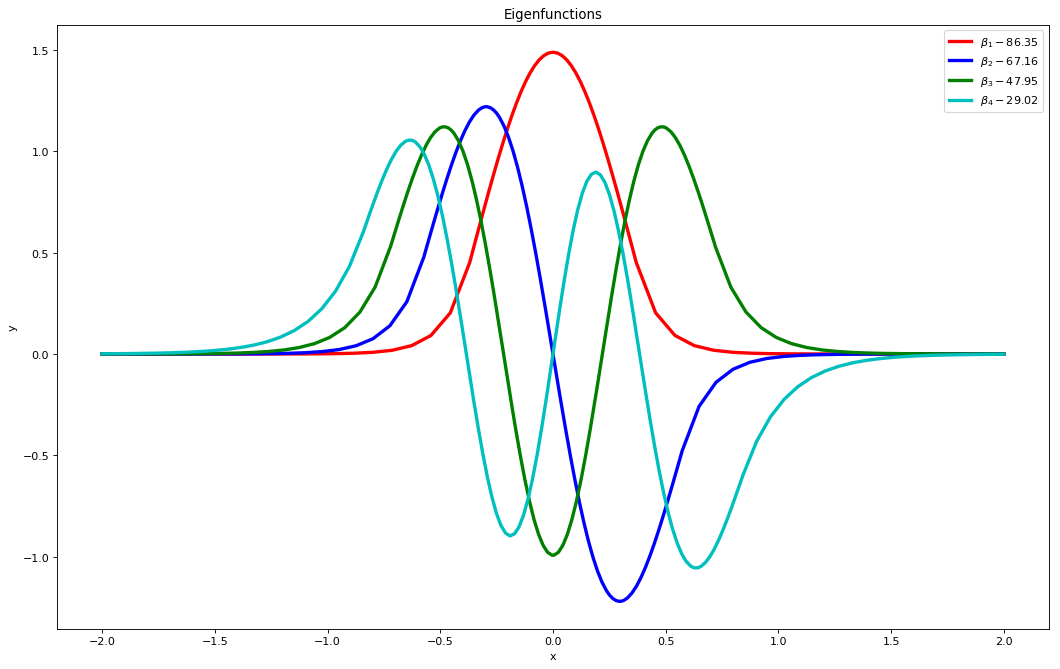

In [1311]:
fig, ax = plt.subplots(figsize=(16,10),facecolor='white',dpi=80)

beta_start = n0     # beginning value of beta
betas = np.zeros((4,))
for modes in range(4):  # begin mode loop
    beta = beta_start   # initial value of eigenvalue beta
    dbeta = n0/20# 100      # default step size in beta
    for m in range(200):   # begin convergence loop for beta
        y0 = np.array([1,np.sqrt(beta)])
        L = np.sqrt(1-beta/n0)
        xspan = L*np.array([-1,0])
        exp_span = np.linspace(-1,-L, 20)
        
        sol = integrate.solve_ivp(lambda x, y : np.array([y[1], (beta-n0*(1-x*x))*y[0]]), xspan,y0,max_step=xstep,method='BDF')
        y = sol.y
        t = sol.t       
        bc = y[1,-1] if 1==(-1)**modes else y[0,-1] #select the relevant quantity to satifsfy boundary condition
        if np.abs(bc-0) < tol: #if boundary value is found within tolerance, print and save the value and break out of loop
            print("Beta Value:",beta)
            betas[modes] = beta;
            break
        #Note that a sign change is needed after computing an even/odd mode pair
        # '//' indicates integer division without remainder
        if (-1)**(modes//2) * bc > 0:#if bc is positive/negative, decrease beta (increase frequency) for even/odd modes
            beta -= dbeta
        else: # oterwise the beta value is too small, so bisect (increase by half the previous increment)
            beta += dbeta/2
            dbeta *= 0.5
    beta_start=beta-.1 #after finding a mode, decrease the starting value for finding the next mode
    exp_span = np.linspace(-2,-L, 20)
    exp_vals = np.exp(np.sqrt(beta)*(exp_span+L))
    half_span = np.concatenate([exp_span,t])
    half_vals = np.concatenate([exp_vals,y[0]])
    complete_span = np.concatenate([half_span,np.flipud(-half_span)])
    complete_vals = np.concatenate([half_vals,np.flipud((-1)**modes*half_vals)])
    norm = np.trapz(complete_vals*complete_vals,x=complete_span) #compute the integral of y**2 for normalization
    ax.plot(complete_span, complete_vals/np.sqrt(norm),colors[modes], linewidth=3) #plot without normalizing

ax.set(title="Eigenfunctions",xlabel="x",ylabel="y");
legend_str = ('$\\beta_{} - {:2.2f}$'.format(n,b) for n,b in enumerate(betas,1))
plt.legend(list(legend_str));

After a bit of work (and learning), this plot nicely replicates the results in Fig. 7.9 on p. 159.

__Direct Solve with Quadratic Potential (pp. 178-9)__

Finally, let's consider another twist on the Schrodinger equation; this time with a quadratic potential that is concave up:

$$-\frac{d^2y}{dx^2} + x^2 y = \lambda y \; ; \; y(\pm L)=0$$

For comparison with the results shown in Fig. 7.14 on p. 179, let's compute on the finite domain $x \in [-4,4]$. The version below implements a direct solution by writing a `make_array` function to construct the matrix version of the discretized ODE and then computing the eigenvalues and eigenvectors.

In [1318]:
from scipy.sparse import diags

def make_array(n,L):
    x = np.linspace(-L,L,n+2) #locations of nodes including boundaries
    dx = (2*L)/(n+1) #spacing between nodes
    b1 = diags([1, -2, 1], [-1, 0, 1], shape=(n,n)).toarray() #standard array for second derivative estimator
    potentials = x[1:-1]*x[1:-1] #value of potential (x^2) at internal nodes
    d =  np.diag(potentials) #diagonal array of potential values
    m = -(1/dx**2)*b1+d #matrix in m.y=lambda*y
    return m

Let's test `make_array` and see if a small matrix has the right form:

In [1319]:
n = 8 #number of computation points in interior of domain
L = 4 #half-width of domain
make_array(n,L)

array([[12.21, -1.27,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.27,  7.47, -1.27,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.27,  4.31, -1.27,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.27,  2.73, -1.27,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.27,  2.73, -1.27,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.27,  4.31, -1.27,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.27,  7.47, -1.27],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.27, 12.21]])

That looks reasonable, so compute the eigenvalues and eigenvectors:

In [1320]:
from numpy import linalg as LA
vals,vecs = LA.eigh(m)
vals

array([  1.  ,   3.  ,   5.  ,   6.99,   9.  ,  11.05,  13.2 ,  15.53,
        18.09,  20.94,  24.07,  27.51,  31.23,  35.25,  39.55,  44.13,
        48.98,  54.1 ,  59.49,  65.13,  71.03,  77.17,  83.55,  90.16,
        97.  , 104.06, 111.34, 118.82, 126.5 , 134.37, 142.43, 150.66,
       159.06, 167.61, 176.33, 185.18, 194.17, 203.28, 212.51, 221.85,
       231.29, 240.82, 250.43, 260.11, 269.85, 279.64, 289.48, 299.35,
       309.25, 319.16, 329.07, 338.98, 348.87, 358.74, 368.58, 378.38,
       388.12, 397.8 , 407.41, 416.93, 426.37, 435.71, 444.94, 454.06,
       463.04, 471.9 , 480.61, 489.17, 497.57, 505.8 , 513.85, 521.72,
       529.4 , 536.88, 544.16, 551.22, 558.06, 564.67, 571.05, 577.19,
       583.08, 588.73, 594.11, 599.23, 604.08, 608.66, 612.96, 616.97,
       620.7 , 624.12, 627.24, 630.05, 632.54, 634.67, 636.49, 637.42,
       639.91, 639.94, 645.02, 645.02])

First 4 eigenvalues:  [1.   3.   5.   6.99]


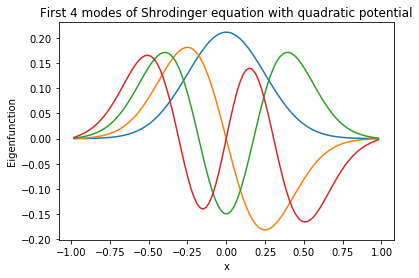

In [1321]:
print("First 4 eigenvalues: ", vals[:4])
plt.plot(b,-vecs.T[0])
plt.plot(b,-vecs.T[1])
plt.plot(b,vecs.T[2])
plt.plot(b,vecs.T[3])
plt.xlabel("x")
plt.ylabel("Eigenfunction")
plt.title("First 4 modes of Shrodinger equation with quadratic potential")
plt.show()